In [2]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import datasets
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

IGNORE_NON_PLAYERS = True
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# load in dataset
animal_crossing_data = pd.read_csv('./Cleaned-Data-for-Data-Science (working on D6 and D7).csv')

# option to drop those who do not play ACNH or not
if IGNORE_NON_PLAYERS:
    animal_crossing_data.drop(animal_crossing_data[animal_crossing_data['Id'].isin([21, 26])].index, inplace=True)

# take only columns relating to environmental perception or socio demographic
animal_crossing_data = animal_crossing_data[[
    'A1_1_What_is_your_nationality_ALTERED',
    'A1_2_Region__generated_from_A1_1_ALTERED',
    'A2_What_is_your_biological_sex_',
    'A3_What_is_the_highest_educational_level_you_have_completed',
    'A4_Do_you_have_a_pet_or__a_garden_at_home_',
    'A5_What_is_your_age_',
    'A6_Please_specify_your_ethnicity_',
    'A7_What_is_your_marital_status_',
    'A8_Employment_Status__Are_you_currently__',
    'C1_How_much_do_you_agree_with_the_following_statements___We_are_approaching_the_limit_of_the_number_of_people_the_earth_can_support_',
    'C2_How_much_do_you_agree_with_the_following_statements___Humans_have_the_right_to_modify_the_natural_environment_to_suit_their_needs__',
    'C3_How_much_do_you_agree_with_the_following_statements___When_humans_interfere_with_nature_it_often_produces_disastrous_consequences__',
    'C4_How_much_do_you_agree_with_the_following_statements___Human_ingenuity_will_insure_that_we_do_not_make_the_Earth_unlivable_',
    'C5_How_much_do_you_agree_with_the_following_statements___Humans_are_seriously_abusing_the_environment__',
    'C6_How_much_do_you_agree_with_the_following_statements___The_Earth_has_plenty_of_natural_resources_if_we_just_learn_how_to_develop_them__',
    'C7_How_much_do_you_agree_with_the_following_statements___Plants_and_animals_have_as_much_right_as_humans_to_exist__',
    'C8_How_much_do_you_agree_with_the_following_statements___The_balance_of_nature_is_strong_enough_to_cope_with_the_impacts_of_modern_industrial_nations_',
    'C9_How_much_do_you_agree_with_the_following_statements___Despite_our_special_abilities__humans_are_still_subject_to_the_laws_of_nature__',
    'C10_How_much_do_you_agree_with_the_following_statements___The_so_called__ecological_crisis__facing_humankind_has_been_greatly_exaggerated__',
    'C11_How_much_do_you_agree_with_the_following_statements___The_Earth_is_like_a_spaceship_with_very_limited_room_and_resources__',
    'C12_How_much_do_you_agree_with_the_following_statements___Humans_were_meant_to_rule_over_the_rest_of_nature__',
    'C13_How_much_do_you_agree_with_the_following_statements___The_balance_of_nature_is_very_delicate_and_easily_upset__',
    'C14_How_much_do_you_agree_with_the_following_statements___Humans_will_eventually_learn_enough_about_how_nature_works_to_be_able_to_control_it__',
    'C15_How_much_do_you_agree_with_the_following_statements___If_things_continue_on_their_present_course__we_will_soon_experience_a_major_ecological_catastrophe__',
]]

# rename columns for convenience
animal_crossing_data.columns = [
    'Nationality',
    'Region',
    'Biological sex',
    'Educational Level',
    'Pet or garden',
    'Age',
    'Ethnicity',
    'Marital status',
    'Employment status',
    'C1',
    'C2',
    'C3',
    'C4',
    'C5',
    'C6',
    'C7',
    'C8',
    'C9',
    'C10',
    'C11',
    'C12',
    'C13',
    'C14',
    'C15',
]

# reset the None values in the pet or garden column
animal_crossing_data.loc[animal_crossing_data['Pet or garden'].isnull(), 'Pet or garden'] = "None"

animal_crossing_data.head()

,Nationality,Region,Biological sex,Educational Level,Pet or garden,Age,Ethnicity,Marital status,Employment status,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15
0,American,US/Canada,Male,Undergraduate school,None,22,Asian,"Single, never married",Employed for wages,4,3,4,3,4,2,4,4,4,3,4,4,4,3,4
1,Vietnamese,Asia,Female,Undergraduate school,A garden,23,Asian,"Single, never married",A student,3,2,4,3,4,2,5,3,4,4,2,4,2,3,4
2,Vietnamese,Asia,Female,High school,A garden,23,Asian,"Single, never married",A student,3,4,3,3,4,2,4,3,4,4,4,4,3,3,4
3,Vietnamese,Asia,Female,Graduate school and higher,A pet,31,Asian,"Single, never married",Employed for wages,3,3,3,3,3,3,5,3,3,3,5,5,3,3,5
4,Vietnamese,Asia,Male,Graduate school and higher,A pet,21,Asian,"Single, never married",A student,1,4,3,3,1,4,1,4,1,3,1,4,3,4,1


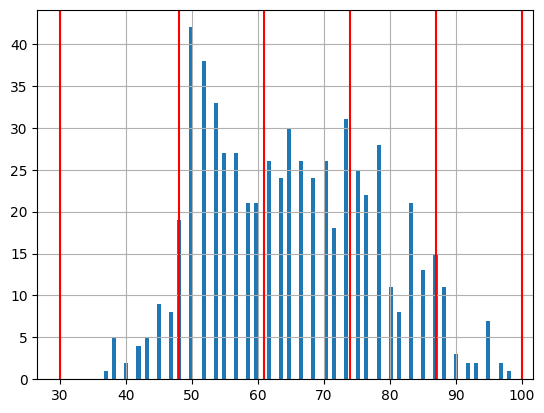

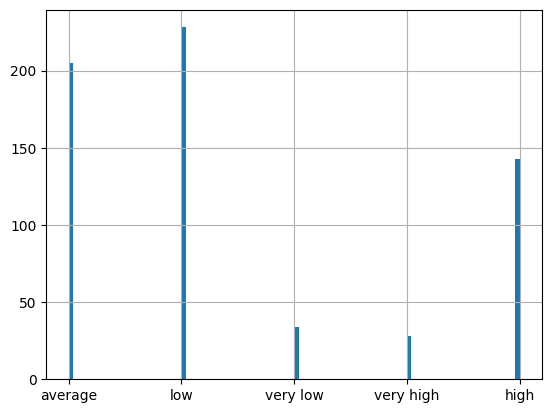

In [4]:
# reverse the scaling on the even numbered C columns so bigger numbers imply environmental perception leaning towards nature rather than human
# NOTE: dugyu says that this has already been done (check on dataset/ website for the dataset etc.)

# calculate the environmental perception score as the averaged perception rescaled to (0 - 100) and drop the original perception columns
nature_awareness_cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
animal_crossing_data['nature awareness'] = (animal_crossing_data[nature_awareness_cols].sum(axis=1) - 15) / (4 * 15) * 100
# animal_crossing_data.drop(columns=nature_awareness_cols, inplace=True)

# sense check nature awareness scores before grouping
animal_crossing_data['nature awareness'].hist(bins=100)

# group the scores into some labels
bins = [30, 48, 61, 74, 87 ,100]
# bins = [0, 20, 40, 60, 80 ,100]
# bins = [0, 52, 60, 69, 77 ,100]
# bins = [0, 45, 55, 67, 80 ,100]
# bins = [0, 50, 62, 69, 80 ,100]

for i in bins:
    plt.axvline(x=i, c = 'r')
plt.show()

# calculate classes and plot the frequency of each class
labels = ['very low', 'low', 'average', 'high', 'very high']
animal_crossing_data['nature awareness'] = pd.cut(animal_crossing_data['nature awareness'], bins=bins, labels=labels)
animal_crossing_data['nature awareness'].hist(bins=100)
plt.show()

In [5]:
# split the data set into the  training and test
features = animal_crossing_data[['Nationality', 'Region', 'Biological sex', 'Educational Level', 'Pet or garden', 'Age', 'Ethnicity', 'Marital status', 'Employment status']]
labels   = animal_crossing_data['nature awareness']

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, random_state=0)

In [6]:
# set our numeric and categoric features
num_cols = ['Age']
cat_cols = ['Nationality', 'Region', 'Biological sex', 'Educational Level', 'Pet or garden', 'Ethnicity', 'Marital status', 'Employment status']

# simple selector for our pipeline to select the right type of feature
class DataFrameSelector(BaseEstimator):
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

# numeric pipelines: select numeric columns and scale them
num_pipeline= Pipeline([
    ('selector', DataFrameSelector(num_cols)),
    # ('std_scaler',StandardScaler())
])

# categoric pipeline: select categoric columns and onehot encode them
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_cols)),
    ('one hot',OneHotEncoder(handle_unknown='ignore'))
])

# full pipeline: run the numeric and categoric pipelines then put the features together
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline)
])

# prepare our train and test data using the pipelines, and sense check a sample
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared  = full_pipeline.transform(X_test)
print('First prepared training sample:\n',  X_train_prepared.toarray()[0,:])

First prepared training sample:
 [24.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [7]:
# set of different parameters for best model
param_grid  = {
    'n_estimators':[50, 100, 300, 500],
    'criterion'   :['gini', 'entropy', 'log_loss'],
    'max_depth'   :[None, 10, 15, 20],
    'max_features':[None, 'sqrt', 'log2']
}

# brute force combinations of these parameters for the best performing result
forest_reg = RandomForestClassifier()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='accuracy', verbose=10)
grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START criterion=gini, max_depth=None, max_features=None, n_estimators=50
[CV 1/5; 1/144] END criterion=gini, max_depth=None, max_features=None, n_estimators=50;, score=0.456 total time=   0.1s
[CV 2/5; 1/144] START criterion=gini, max_depth=None, max_features=None, n_estimators=50
[CV 2/5; 1/144] END criterion=gini, max_depth=None, max_features=None, n_estimators=50;, score=0.416 total time=   0.1s
[CV 3/5; 1/144] START criterion=gini, max_depth=None, max_features=None, n_estimators=50
[CV 3/5; 1/144] END criterion=gini, max_depth=None, max_features=None, n_estimators=50;, score=0.348 total time=   0.1s
[CV 4/5; 1/144] START criterion=gini, max_depth=None, max_features=None, n_estimators=50
[CV 4/5; 1/144] END criterion=gini, max_depth=None, max_features=None, n_estimators=50;, score=0.371 total time=   0.1s
[CV 5/5; 1/144] START criterion=gini, max_depth=None, max_features=None, n_estimators=50
[CV 5/5; 1/1

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 10, 15, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 300, 500]},
             scoring='accuracy', verbose=10)

In [8]:
# inspect the top 10 best performing models
cvres = grid_search.cv_results_
pd.DataFrame(cvres).sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
69,0.079478,0.001918,0.003691,0.000226,entropy,10,log2,100,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.455556,0.494382,0.471910,0.426966,0.595506,0.488864,0.057673,1
114,0.248571,0.001608,0.009422,0.000080,log_loss,10,sqrt,300,"{'criterion': 'log_loss', 'max_depth': 10, 'ma...",0.466667,0.505618,0.483146,0.426966,0.550562,0.486592,0.041032,2
117,0.080629,0.000513,0.003660,0.000105,log_loss,10,log2,100,"{'criterion': 'log_loss', 'max_depth': 10, 'ma...",0.477778,0.449438,0.494382,0.438202,0.573034,0.486567,0.047608,3
19,0.377809,0.004509,0.014929,0.000148,gini,10,sqrt,500,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.466667,0.494382,0.471910,0.415730,0.573034,0.484345,0.051267,4
71,0.387398,0.003736,0.014841,0.000062,entropy,10,log2,500,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.455556,0.494382,0.460674,0.415730,0.573034,0.479875,0.052846,5
68,0.041060,0.000639,0.002216,0.000123,entropy,10,log2,50,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.455556,0.516854,0.471910,0.404494,0.539326,0.477628,0.047358,6
118,0.234757,0.002390,0.009252,0.000048,log_loss,10,log2,300,"{'criterion': 'log_loss', 'max_depth': 10, 'ma...",0.455556,0.483146,0.483146,0.382022,0.584270,0.477628,0.064901,6
17,0.077191,0.000837,0.003535,0.000078,gini,10,sqrt,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.455556,0.471910,0.460674,0.415730,0.573034,0.475381,0.052375,8
119,0.393483,0.001404,0.015119,0.000304,log_loss,10,log2,500,"{'criterion': 'log_loss', 'max_depth': 10, 'ma...",0.477778,0.494382,0.438202,0.415730,0.550562,0.475331,0.046817,9
18,0.228239,0.002895,0.009299,0.000121,gini,10,sqrt,300,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.500000,0.449438,0.449438,0.415730,0.561798,0.475281,0.050947,10


Training:
        Accuracy:  0.8946188340807175
        Precision: 0.8991815368560271
        Recall:    0.8946188340807175
        F1 score:  0.8922050212904524
    
Test:
        Accuracy:  0.4114583333333333
        Precision: 0.3882103338334583
        Recall:    0.4114583333333333
        F1 score:  0.3950838463742863
    


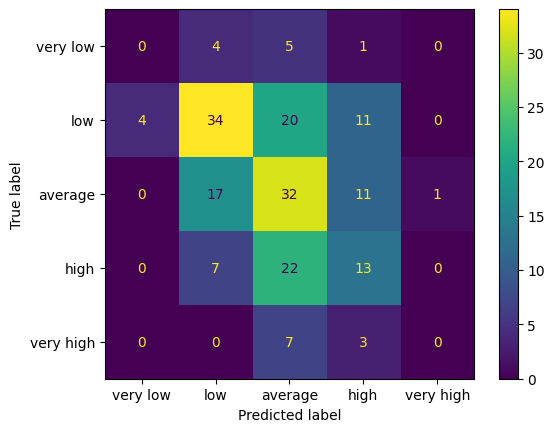

In [9]:
def display_scores(y_true, y_pred, type=None):
    accu = metrics.accuracy_score (y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred, average='weighted')
    reca = metrics.recall_score   (y_true, y_pred, average='weighted')
    f1sc = metrics.f1_score       (y_true, y_pred, average='weighted')
    type = type + ':' if type != None else ''

    print(f'''{type}
        Accuracy:  {accu}
        Precision: {prec}
        Recall:    {reca}
        F1 score:  {f1sc}
    ''')

# take the best model
best_model = grid_search.best_estimator_

# test on training data
y_pred = best_model.predict(X_train_prepared)
display_scores(y_train, y_pred, 'Training')

# test on test data
y_pred = best_model.predict(X_test_prepared)
display_scores(y_test, y_pred, 'Test')

# plot a confusion matrix for the test data
classes = ['very low', 'low', 'average', 'high', 'very high']
cf = metrics.confusion_matrix(y_test, y_pred, labels=classes)
dis = metrics.ConfusionMatrixDisplay(cf, display_labels=classes)
dis.plot()
plt.show()